<a href="https://colab.research.google.com/github/Giuseppe31-s/Desafio-Cientista-de-Dados-oncase/blob/main/Desafio_oncase_S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/time_series_data.zip

Archive:  /content/time_series_data.zip
  inflating: time_series_data.xlsx   


In [ ]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import q_stat
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings("ignore")

In [ ]:

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [ ]:
df = pd.read_excel('/content/time_series_data.xlsx')

# Limpeza básica

Não há valores faltantes.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   produto_descricao                       4460 non-null   object 
 1   produto_quantidade                      4460 non-null   int64  
 2   produto_unidade_comercial               4460 non-null   object 
 3   produto_valor_unitario_comercializacao  4460 non-null   float64
 4   nota_data_emissao                       4460 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3+ KB


In [ ]:
df

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
0,A0,23568,UN,14.1300,20210420
1,A0,25082,UN,14.1300,20210420
2,A0,25430,UN,14.1300,20210922
3,A0,25463,UN,12.8400,20210209
4,A0,25800,UN,12.8400,20210209
...,...,...,...,...,...
4455,B3,60,UN,3.1500,20210125
4456,B3,85,UN,3.1500,20210120
4457,B0,11400,UN,4.6477,20210226
4458,B0,22800,UN,4.6477,20210226


Vamos verificar se o nosso conjunto contém valores duplicados

In [ ]:
df.duplicated().value_counts()

False    3827
True      633
dtype: int64

Como pode ser visto, há sim valores faltantes e vamos removê-los.

In [ ]:
df.drop_duplicates(inplace= True)

# Análise exploratória para identificar o melhor produto.

Não há valores nulos no nosso dataset, logo não vai ser preciso lidar com isso.


Vamos escolher um produto com uma boa quantidade de amostras. Dentre as
s opções, vamos verificar alguns produtos.

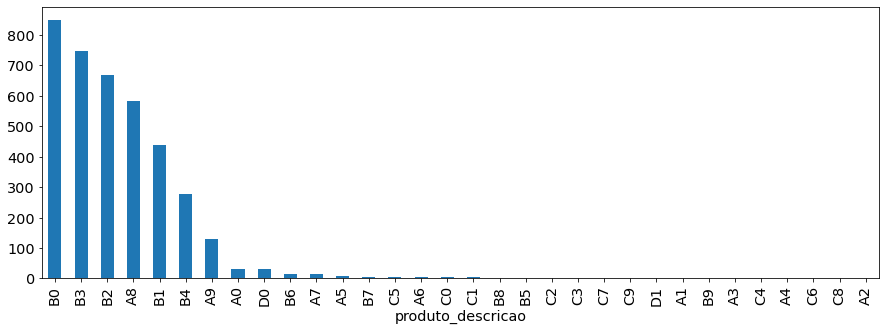

In [ ]:
df.groupby('produto_descricao').count()['produto_quantidade'].sort_values(ascending = False).plot(kind='bar');

In [ ]:
produtos = ['B0', 'B3', 'B2', 'A8', 'B1']
df[df['produto_descricao'].isin(produtos)].groupby('produto_descricao')['produto_quantidade'].describe()


,count,mean,std,min,25%,50%,75%,max
produto_descricao,,,,,,,,
A8,581.0,320.962134,780.711474,1.0,45.0,115.0,315.0,12870.0
B0,850.0,709.104706,2244.179291,1.0,60.0,240.0,600.0,42000.0
B1,437.0,369.384439,1768.545464,1.0,45.0,62.0,135.0,21554.0
B2,667.0,235.677661,1034.266813,1.0,24.0,48.0,120.0,16852.0
B3,746.0,146.371314,270.089083,1.0,24.0,72.0,144.0,3096.0


Transformando nota_data_emissao em um datetime, para ficar melhor a visualização.

In [ ]:
df['nota_data_emissao'] = pd.to_datetime(df['nota_data_emissao'], format = '%Y%m%d')

Vamos ver o comportamento dos 5 produtos com maior demanda.


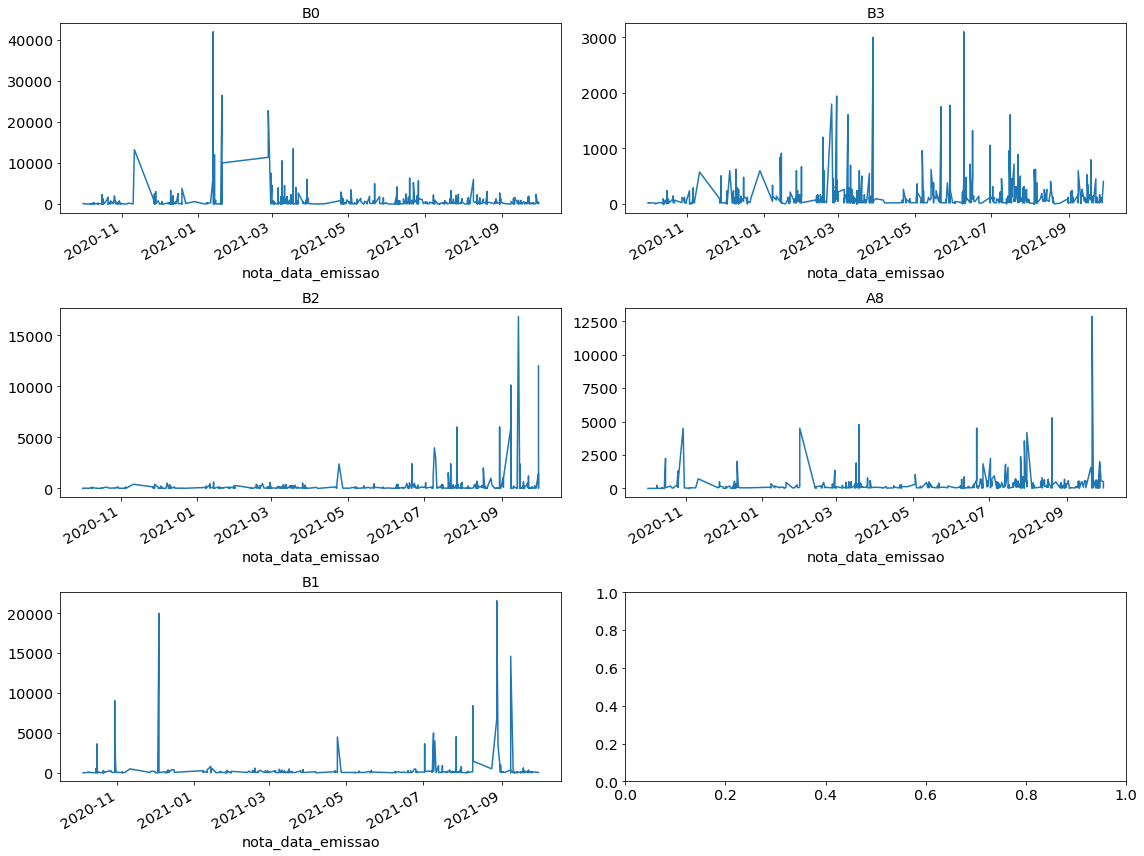

In [ ]:


produtos = ['B0', 'B3', 'B2', 'A8', 'B1']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

for ax, produto in zip(axs.flatten(), produtos):
    dados = df[df['produto_descricao'] == produto].set_index('nota_data_emissao')
    dados['produto_quantidade'].plot(ax=ax)
    ax.set_title(produto)

plt.tight_layout()
plt.show()


Vamos recriar a mesma visualização mas agrupando por mês.

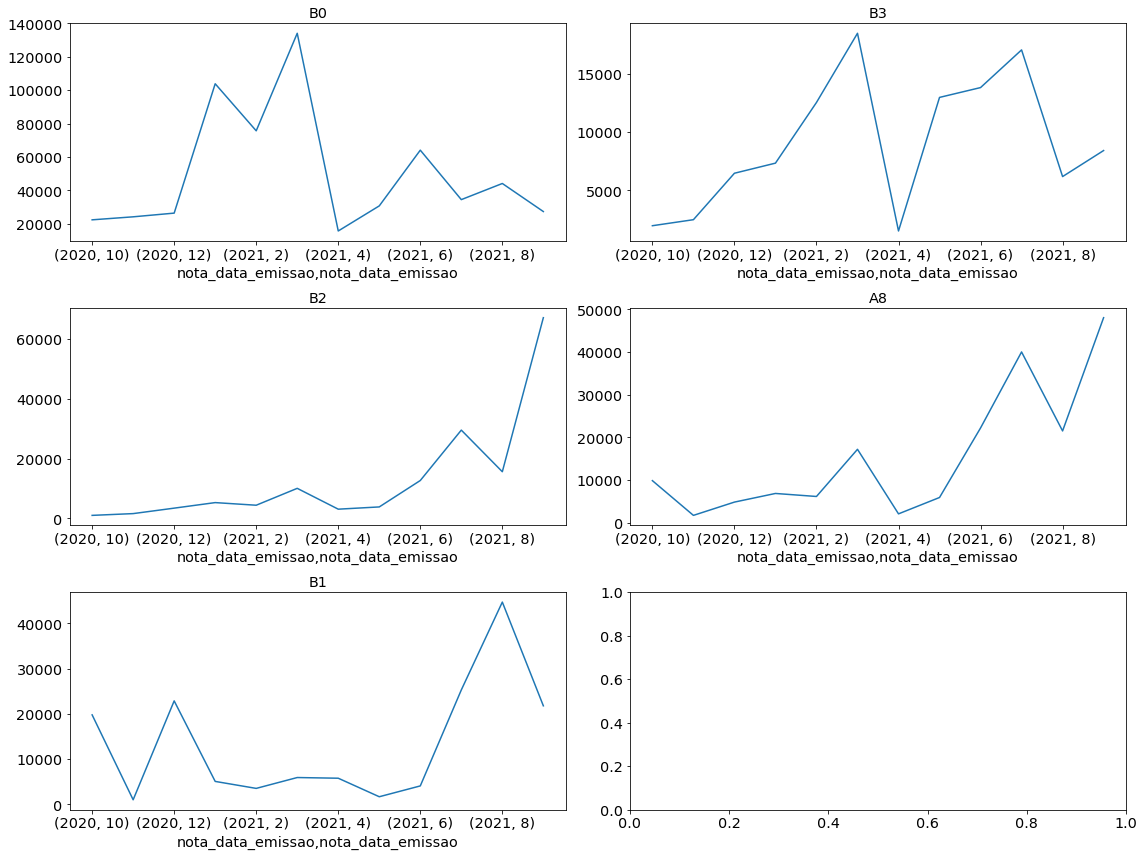

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

for ax, produto in zip(axs.flatten(), produtos):
    dados = df[df['produto_descricao'] == produto].set_index('nota_data_emissao')
    dados = dados.groupby([dados.index.year, dados.index.month])['produto_quantidade'].sum()
    dados.plot(ax=ax)
    ax.set_title(produto)

plt.tight_layout()
plt.show()


# Escolha do produto

Para o desafio vou escolher o produto B0, depois do 05 de 2021 ele da uma estabilizada.

In [ ]:
df = df[df['produto_descricao'] == 'B0'].set_index('nota_data_emissao')

In [ ]:
df.index.max() - pd.Timedelta(days = 4)

Timestamp('2021-09-26 00:00:00')

Como vou fazer uma previsão de apenas 4 intervalos para frente, vou utilizar 30, 60 e 90 dias para treinar o nosso modelo.

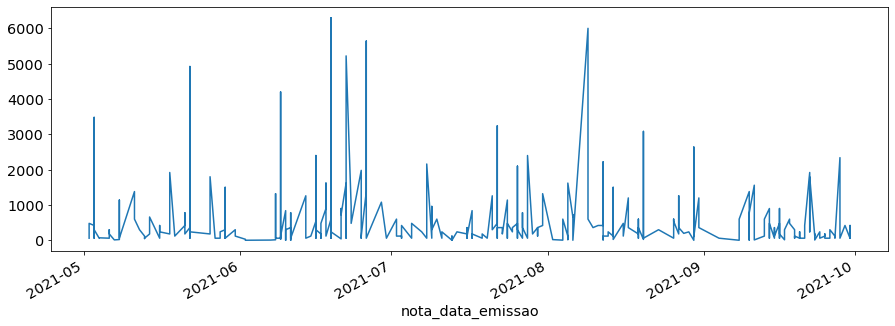

In [ ]:
df[df.index > '2021-05-01']['produto_quantidade'].plot()

In [ ]:
df.index.max() - pd.Timedelta(days = 4)

Timestamp('2021-09-26 00:00:00')

Ao examinar um pouco melhor os dados, percebi que há vários dias que tem mais de 1 pedido, vamos juntar para não gerar conflito na hora da previsão.

In [ ]:
df[df.index >= '2021-09-26']

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao
nota_data_emissao,,,,
2021-09-30,B0,180,UN,32.02
2021-09-30,B0,420,UN,32.02
2021-09-27,B0,120,UN,32.24
2021-09-30,B0,60,UN,32.47
2021-09-29,B0,420,UN,32.47
2021-09-27,B0,60,UN,32.02
2021-09-26,B0,300,UN,32.47
2021-09-28,B0,60,UN,29.94
2021-09-30,B0,60,UN,32.02


Juntado as quantidades por dia

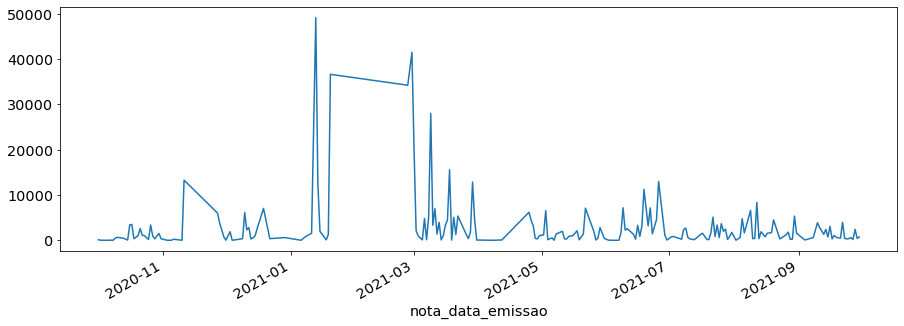

In [ ]:
df.groupby(df.index)['produto_quantidade'].sum().plot()

In [ ]:
df = pd.DataFrame(df.groupby(df.index)['produto_quantidade'].sum())
df

,produto_quantidade
nota_data_emissao,
2020-10-01,120
2020-10-02,14
2020-10-05,1
2020-10-07,30
2020-10-08,1
...,...
2021-09-26,600
2021-09-27,180
2021-09-28,2400


In [ ]:
treino = df[df.index < '2021-09-26']
teste = df[df.index > '2021-09-26']

In [ ]:
dias30 = treino.index.max() - pd.Timedelta(days = 30)
dias60 = treino.index.max() - pd.Timedelta(days = 60)
dias90 = treino.index.max() - pd.Timedelta(days = 90)

In [ ]:
treino30 = treino[treino.index > dias30]
treino60 = treino[treino.index > dias60]
treino90 = treino[treino.index > dias90]


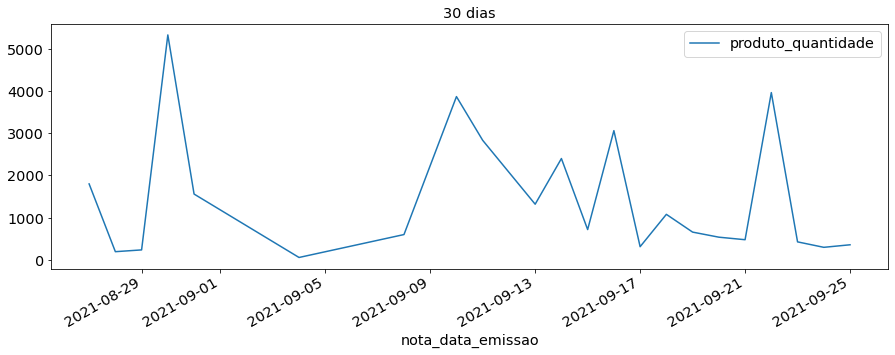

In [ ]:

treino30.plot(title = '30 dias')

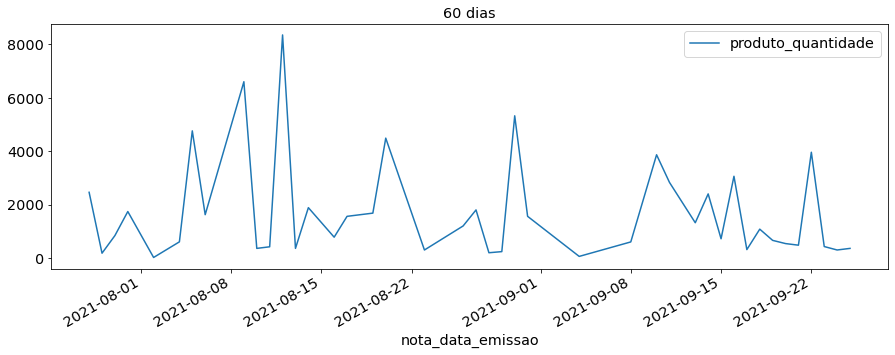

In [ ]:
treino60.plot(title = '60 dias');

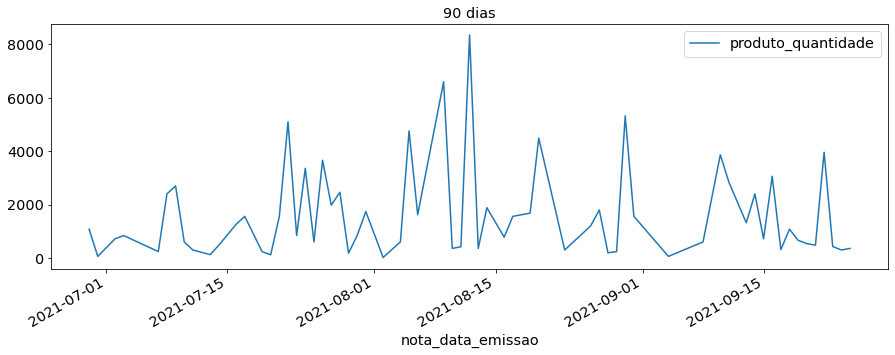

In [ ]:
treino90.plot(title = '90 dias');

###ESTACIONARIEDADE
Na análise de regressão envolvendo dados de séries temporais, uma premissa fundamental é que a série temporal considerada seja estacionária. De modo geral, uma série temporal é estacionária se sua média e variância forem constantes ao longo do tempo e o valor de covariância entre dois períodos depender apenas da distância ou intervalo entre os dois períodos e não do tempo real no qual a covariância é calculada.1 Uma série temporal é um exemplo do que se conhece por um processo estocástico, que é uma sequência de variáveis aleatórias ordenadas no tempo.

###IMPORTÂNCIA DA ESTACIONARIEDADE

Que diferença faz se uma série temporal for estacionária ou não? Há várias razões para isso. Para começar, se uma série temporal for não estacionária, só podemos estudar seu comportamento no período em consideração. Desse modo, cada série temporal será um episódio específico. Como resultado, não é possível generalizá-la para outros períodos. Para fins de previsão, portanto, as séries temporais não estacionárias terão pouco valor prático. Em segundo lugar, se tivermos duas ou mais séries temporais não estacionárias, a análise de regressão
envolvendo essas séries temporais pode levar ao fenômeno da regressão espúria ou sem sentido. Em outras palavras, se fizermos a regressão de uma série temporal não estacionária contra uma ou mais séries temporais não estacionárias, poderemos obter um valor alto de R2
e alguns coeficientes de regressão (ou todos) podem
ser estatisticamente significativos com base nos testes t e F habituais. Infelizmente, em casos de séries temporais não estacionárias, esses testes não são confiáveis, pois presumem que as séries temporais que os fundamentam são estacionárias.

##TESTE DE ESTACIONARIEDADE

Há basicamente três formas para sabermos se uma série é estacionária ou não.

* Análise gráfica

*  Autocorrelação e correlogramas 

* Análise de raiz unitária

###Análise gráfica

Vamos criar uma gráfico a fim de observar se a nossa série segue uma tendência a sazonalidade do mesmo, âmbos são prejudiciais para o nosso modelo, mas a tendência descola a média pra cima anulado a estacionariedade. Se o nosso gráfico tem tendência já é uma red flag.

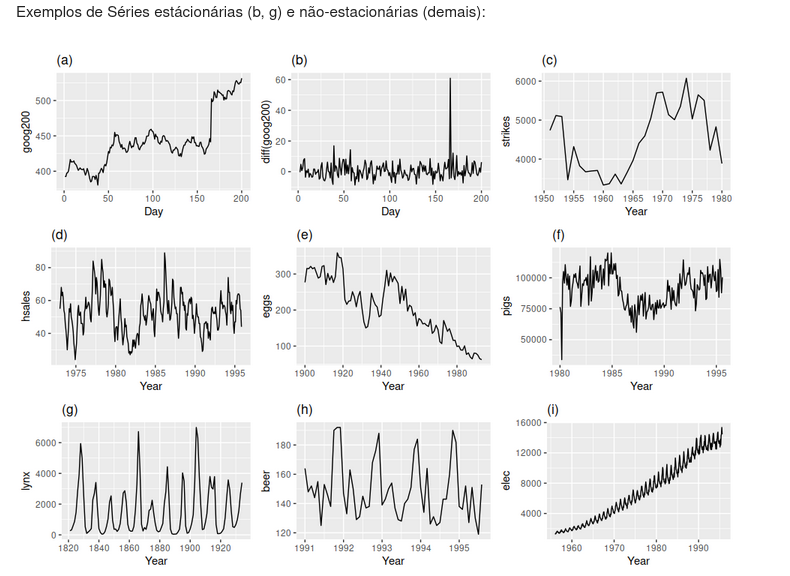

**Vou usar o treino 60 para demonstração.**

Visualmente, o gráfico não parece ter estacionariedade.

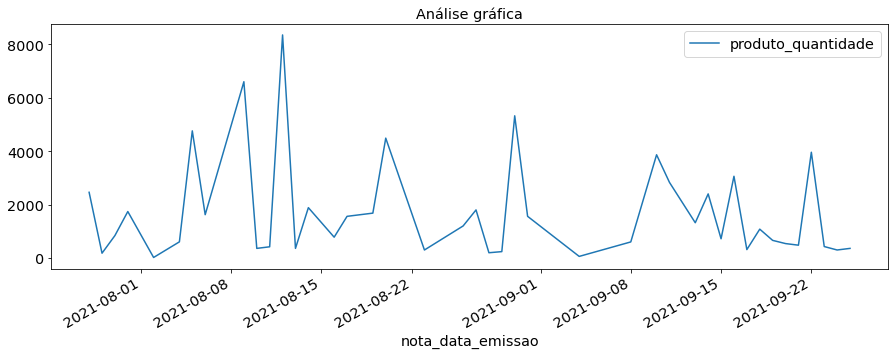

In [ ]:
treino60.plot(title = 'Análise gráfica');

##Autocorrelação

Para verificar até que ponto no passado a correlação se estende, podemos obter a chamada **função de autocorrelação (FAC)**. A FAC com defasagem k é definida como:

$$\rho_k = \frac{\gamma_k}{\gamma_0} = \frac{covariância \ com \ defasagem \ k}{variância} = \phi^k$$ 

uma regra prática é calcular a FAC
até entre 1/4 e 1/3 da duração da série temporal.

In [ ]:
int(treino60.shape[0]* (1/4))

10

1/4 do nosso dataset é 10, logo vamos testar a autocorrelação até um lag de 10.

In [ ]:
info = dict()

for i in range(1,11):
  info.update({f'Lag {i}': treino60['produto_quantidade'].autocorr(i)})
  

tabori = pd.DataFrame(pd.Series(info)).rename(columns = {0:'Correlação de Person'})

tabori.head(10)

,Correlação de Person
Lag 1,-0.217104
Lag 2,-0.102106
Lag 3,0.129082
Lag 4,-0.048218
Lag 5,0.082414
Lag 6,0.096504
Lag 7,-0.209672
Lag 8,-0.034658
Lag 9,0.052700
Lag 10,-0.158730


Uma plotagem de $ρ^k$ contra $k$, a duração da defasagem, é chamada de correlograma (amostral).

Devemos mencionar um tipo especial de série temporal, a saber, uma série temporal
puramente aleatória, ou de ruído branco. Uma série temporal como essa tem média constante, variância constante (isto é, homocedástica) e é não correlacionada seriamente. Ou seja, se a nossa tabela tivesse valores iguais a 0 ou muito próximo do mesmo, iríamos precisar fazer ajustes e normalização. Caso nesses processos o resultado fosse o mesmo, as séries não seriam possíveis de prever. Para uma série temporal como essa, a FAC em várias defasagens gira em torno de zero e o correlograma não mostra qualquer padrão discernível.

Podemos testar a significância estatística de cada coeficiente de autocorrelação calculando seu erro padrão. O estatístico Bartlett demonstrou que, se uma série temporal for puramente aleatória, a autocorrelação amostral, $ρ^k$
, é aproximadamente distribuída (isto é, em grandes amostras) como segue: 
###$$\hat{ρ} \sim N(0,1/n)$$


Ou seja, em grandes amostras a série temporal é aproximadamente normalmente distribuída com média zero e variância igual a 1 sobre o tamanho da amostra. O tamanho da nossa amostra é 42. Portanto, a variância é 1/42 ou cerca de 0.023 e o erro padrão é $\sqrt{0.023} = 0.15$. Desse modo, de acordo com as propriedades da distribuição normal, o intervalo de confiança de 95% para $ρ_k$
é $[0 ± 1,96(0.15)]$ ou
$(–0,294 \ a \  0,294)$. Todas as correlações estimadas estão nesse intervalo. Desse modo, podemos concluir que  os
coeficientes de autocorrelação estimados mostrados na tabela são estatisticamente insignificantes. Trata-se de um sinal que o dataframe seja estacionário.

Em vez de avaliar a significância estatística de um coeficiente de autocorrelação individual, também pode-mos descobrir se a soma dos coeficientes de autocorrelação ao quadrado é estatisticamente significativa. Isso pode ser feito com o auxílio da estatística Q desenvolvida por Box e Pierce, que é definida como

####$$Q = n \sum_{k = 1}^{m} \hat{p}^2_k  $$

onde n é o tamanho da amostra (42, no nosso exemplo) e m é o número total de defasagens utilizadas no cálculo da FAC, 10, no nosso exemplo. A estatística Q é muito utilizada para testar se uma série temporal é puramente aleatória ou de ruído branco. 

Em grandes amostras, Q é aproximadamente distribuído como a distribuição qui-quadrado com m gl. Se, em uma aplicação, o valor calculado de Q for maior que o valor crítico de Q a partir da distribuição qui-qua-drado no nível escolhido de significância, podemos rejeitar a hipótese nula de que todos os ρk
iguais a zero.

In [ ]:
def is_random(p_value, alpha=0.05):
    if p_value < alpha:
        return False  # Rejeita hipótese nula, não é aleatório
    else:
        return True   # Não pode rejeitar hipótese nula, é aleatório


In [ ]:
q_statistic, p_values = q_stat(tabori['Correlação de Person'], 42)
tabori['Estatística de Q'] = q_statistic.round(2)
tabori['Prob de Q'] = p_values.round(2)
tabori['Aleatório'] = tabori['Prob de Q'].apply(lambda p: is_random(p))


In [ ]:
tabori

,Correlação de Person,Estatística de Q,Prob de Q,Aleatório
Lag 1,-0.217104,2.12,0.14,True
Lag 2,-0.102106,2.61,0.27,True
Lag 3,0.129082,3.40,0.33,True
Lag 4,-0.048218,3.51,0.48,True
Lag 5,0.082414,3.85,0.57,True
Lag 6,0.096504,4.33,0.63,True
Lag 7,-0.209672,6.65,0.47,True
Lag 8,-0.034658,6.71,0.57,True
Lag 9,0.052700,6.87,0.65,True
Lag 10,-0.158730,8.32,0.60,True


A probabilidade de obter esse valor de Q é elevada. Ou seja, a nossa série temporal é não estacionária. Para resumir, há fortes evidências de que a nossa série temporal seja não estacionária.

##O TESTE DE RAIZ UNITÁRIA DA ESTACIONARIEDADE

Podemos usar um teste desenvolvido pelos estatísticos Dickey e Fuller, chamado de **teste τ (tau)**, cujos valores críticos são calculados por meio de simulações – programas estatísticos modernos. São capazes de fazer esses cálculos com facilidade. Na literatura, o teste tau é conhecido como o **teste de Dickey-Fuller (DF)**.

In [ ]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [ ]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(treino60['produto_quantidade'], printResults = True)
print("Essa séries temporal é estacionária? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -5.495394
P-Value                  0.000002
# Lags Used              1.000000
# Observations Used     40.000000
Critical Value (1%)     -3.605565
Critical Value (5%)     -2.937069
Critical Value (10%)    -2.606986
dtype: float64
Essa séries temporal é estacionária? True


##SÉRIES TEMPORAIS DE DIFERENÇA ESTACIONÁRIA

Há duas maneiras comuns para remover a tendência dos nossos dados:

* Regressão linear

* Diferenciação

Na regressão linear, onde:

$$ \hat{Y} = \beta_0 + \beta_1t $$

$t$ =  variável de tendência assumindo valores cronológicos, 1, 2, ..., n.

Feita a estimátiva da tendência atráves da regressão linear podemos removê-la, da seguinte forma:

$$y_ {detrend} = y_t - \hat{y} = y_t - β_0 + \beta_1t $$



Agora passamos a obter uma série sem tendêcia. O procedimento que acabamos de descrever será válido se a série original apresentar uma **tendência determinística**. 


A diferenciação consiste em tomar diferenças sucessivas da série original até se obter uma série estacionária. A primeira diferença de $Z_t$ é definida por.

A primeira diferença de $Z(t)$ é definida por


$$ Δ Z(t) = Z(t) - Z(t-1)$$

A segunda diferença é

$$ Δ^2Z(t) = Δ\left [ ΔZ(t) \right ] = Δ[Z(t) - Z(t-1)] $$

ou seja,

$$Δ^2Z(t) = Z(t) - 2Z(t-1)+ Z(t-2)$$

De modo geral, a n-ésima diferença de Z(t) é

$$Δ^nZ(t) = Δ[Δ^{n-1}Z(t)]$$


Se uma série temporal se tornar estacionária quando removermos sua tendência com a regressão linear,
isso é chamado de um **processo (estocástico) de tendência estacionária (PTE)**. Se uma série temporal se tornar estacionária depois de tomarmos suas primeiras diferenças, chamare-mos essa série temporal de **processo (estocástico) de diferença estacionária (PDE)**.

###Séries temporais integradas

Em textos sobre as séries temporais, é comum ver o termo **“série temporal integrada”**. Se uma série
temporal como essa se tornar estacionária depois de ser diferenciada uma vez, dir-se-á que ela é integrada de ordem um, indicada como I(1). Se ela tiver de ser diferenciada duas vezes (ou seja, a diferença da diferença) para se tornar estacionária, dir-se-á que ela é integrada de ordem dois, indicada como I(2). Se precisar ser diferenciada d vezes para se tornar estacionária, dir-se-á que ela é integrada de ordem d, denotada como I(d). Uma série temporal estacionária é I(0), ou seja, integrada de ordem zero. Desse modo, os termos “série temporal estacionária” e “série temporal integrada de ordem zero” significam a mesma coisa. Seguindo essa mesma lógica, se uma série temporal for integrada, ela é não estacionária.



In [ ]:
treino60 = treino60.diff().dropna()
treino60.head()

,produto_quantidade
nota_data_emissao,
2021-07-29,-2280.0
2021-07-30,660.0
2021-07-31,900.0
2021-08-02,-1720.0
2021-08-04,585.0


##Modelo Autoregressivo (AR)

O AR toma como premissa que o passado prediz o futuro. Dessa forma ele pressupõe que um processo de série temporal no qual o valor em um ponto no tempo t é uma função dos valores da série em um ponto anterior no tempo. 

A autoregressão é uma regressão em valores passados para predizer valores futuros. O modelo AR(1) se expressa da seguinte forma:

$$y_t = \beta_0 + \beta_1 \cdot y_{t-1} + \epsilon_t$$

Esse é o modelo AR(1) que considera o passado apenas no momento imediato anteior, pois apenas está com um lag de 1.


A generalização da notação anterior onde p é um valor qualquer inferior ao t, podemos rescever a nossa expressão da seguinte forma.
Vamos usar a notação mais trandicional, que usa $\phi_1$ para representar os coeficientes de autoregressão:

AR(p):

$$ y_t = \phi_0 + \phi_1 \cdot y_{t-1} + \phi_2 \cdot y_{t-2} + ... + \phi_p \cdot y_{t-p} + \epsilon_t $$

Assumiso que o processo é estacionário, assim sabemos que o valor esperado em todos os tempo deve ser o mesmo.

$$E(y_t) = \mu = E(y_{t-1})$$

Que pode ser rescrita dessa forma:

$$E(y_t) = E(\phi_0 + \phi_1 \cdot y_{t-1} + \epsilon_t)$$

A esperança de uma constante é a mesma constante, e a gente sabe que a esperança do erro é 0, logo:


$$E(y_t) = \phi_0 + \phi_1 + \mu $$

Simplificando:

$$\mu = \phi_0 + \phi_1 \cdot \mu$$


Que gera a equação:

$$\mu - \phi_1*\mu = \phi_0$$

$$\mu(1-\phi_1) = \phi_0$$

$$\mu = \frac{\phi_0}{1 - \phi_1}$$

Assim encontramos a relação entre a média do processo e os coeficientes AR(1).

Podemos seguir nessa mesma linha para ver como a variância e covariância  constante impõem  condições aos coeficientes $\phi$.

Se:

$$\phi_0 = \mu \cdot (1-\phi_1)$$

Então:

$$y_t = \phi_0 + \phi_1 \cdot y_{t-1} + \epsilon_t$$

$$y_t = (\mu -\mu \cdot \phi_1) + \phi_1 \cdot y_{t-1} + \epsilon_t$$

$$y_t - \mu = \phi_1 (y_{t-1} - \mu) + \epsilon_t$$

Como a séries é estacionária, o calcúlo par t serve para t-1:

$$y_{t-1} - \mu = \phi_1 (y_{t-2} - \mu) + \epsilon_{t-1}$$

Podemos substituir o $y_{t-1}$ na primeira equação de $y_t -\mu$

$$y_t - \mu = \phi_1(\phi_1(y_{t-2} - \mu) + \epsilon_{t-1}) + \epsilon_t$$

O mesmo pode ser feito por $y_{t-2}$.

$$y_t - \mu = \phi_1(\phi_1(\phi_1(y_{t-3 }- \mu)+  \epsilon_{t-2})+ \epsilon_{t-1}) + \epsilon_t$$

Simplificando:

$$y_t -\mu = \epsilon_t + \phi_1 \cdot \epsilon_{t-1} + \phi_1^2 \cdot \epsilon_{t-2} + \phi_1^3 \cdot \epsilon_{t-3}+...+ \phi_1^p \cdot \epsilon_{t-p}$$

Assim para $\infty $ casos, temos:

$$y_t - \mu = \sum^{\infty}_{i= 1} \phi_1^i \cdot \epsilon_{t-i}$$


###Função de autocorrelação

A autocorrelação dá uma visão de como os pontos em diferentes períodos no tempo estão linearmente relacionados entre si em função de sua diferença de tempo.

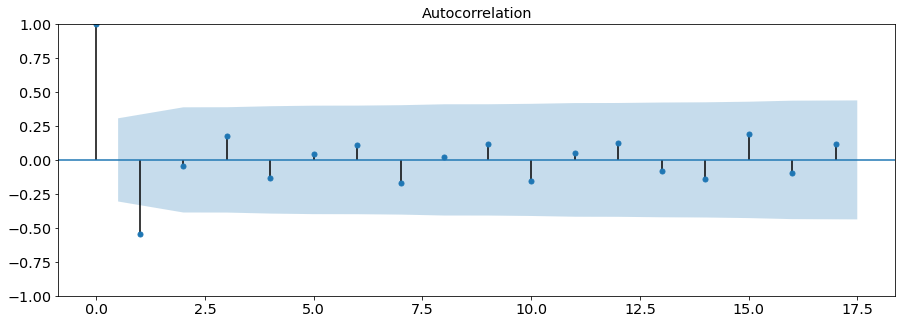

In [ ]:
plot_acf(treino60)
plt.show();

### Função de autocorrelação parcial

A autocorrelação parcial de uma série temporal para um determinando lag é a correlação parcial dessa série temporal com ela mesma nesse lag, dadas todas as informações entre os dois pontos no tempo.

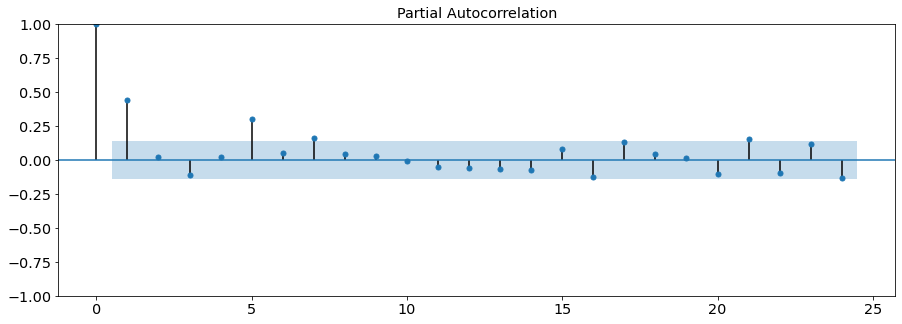

In [ ]:
plot_pacf(df)
plt.show();

Com esses dois gráficos podemos perceber que o nosso modelo tem um AR baixo e MA com uma significância um pouco mais tênue. Vamos agora criar o nosso modelo ARIMA.



##ARIMA
Definido pelas ordens: AR (q), I (d) e MA (q) + Erro advindo do ruído da série.

Um ARIMA definido por (1, 0, 1) é dado por:

$$y_t = \mu + \phi y_{t-1} + \theta y_{y-1} + \epsilon_t$$

In [ ]:
treino60 = treino60.reset_index(drop = True)

In [ ]:
treino_60 = treino60[:int(len(treino60)*(3/4))]
teste_60 = treino60[int(len(treino60)*(3/4)):]

In [ ]:
treino_60.index.max()

29

In [ ]:
#Fazendo um arima na "mão"
from statsmodels.tsa.arima.model import ARIMA


arima = ARIMA(treino_60, order=(3,0,1))
arima_fit = arima.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     produto_quantidade   No. Observations:                   30
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -271.763
Date:                Thu, 16 Feb 2023   AIC                            555.526
Time:                        18:38:01   BIC                            563.934
Sample:                             0   HQIC                           558.216
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5625     47.679      0.075      0.940     -89.886      97.011
ar.L1         -0.2482      0.382     -0.650      0.516      -0.997       0.500
ar.L2         -0.1630      0.240     -0.679      0.4

In [ ]:
teste.index.min()

Timestamp('2021-09-27 00:00:00')

In [ ]:
predito_ARIMA = arima_fit.predict(start = teste_60.index.min(),end = teste_60.index.max())

In [ ]:
ci = 1.96 * np.std(teste_60)/np.sqrt(len(teste_60))

Nosso modelo não conseguiu se adaptar aos dados. Vamos mudar a abordagem e utilizar algo mais moderno.

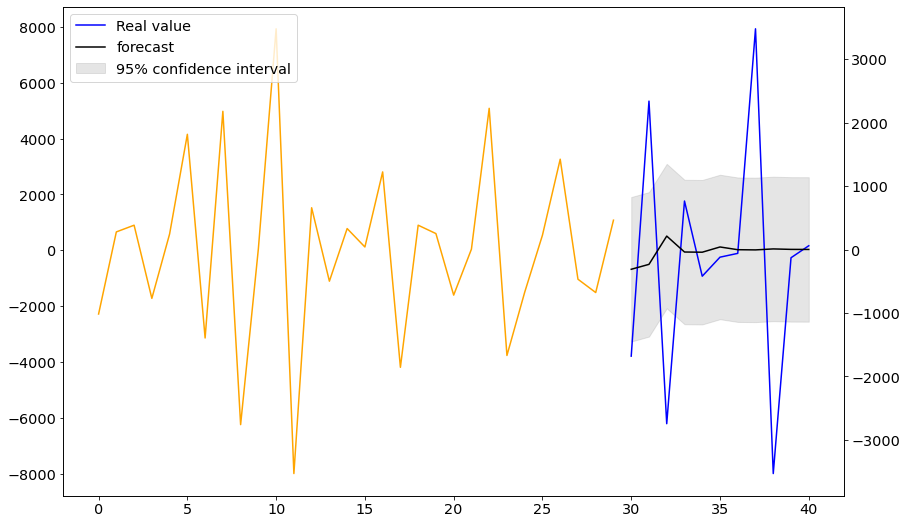

In [ ]:
fig, ax = plt.subplots(figsize = (14,9))
ax.plot(treino_60.index, treino_60, color='orange')
ax2 = ax.twinx()
ax2.plot(teste_60.index, teste_60, color='blue', label = 'Real value')
ax2.plot(teste_60.index, predito_ARIMA, color='black',label='forecast')
ax2.fill_between(teste_60.index, (predito_ARIMA .values -ci.values), (predito_ARIMA .values+ci.values), color='gray', alpha=.2,label = "95% confidence interval")

plt.legend()
plt.show()


Vamos utilizar do Machine Learning para tentar melhorar o resultado da nossa previsão.

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pmdarima.arima import AutoARIMA
modelo_autoarima = AutoARIMA( start_p= 1, start_q = 1,start_d = 0,trace = True, max_d = 2,error_action = 'ignore',stepwise = False)

In [ ]:
modelo_autoarima.fit(treino_60)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=574.468, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=554.888, Time=0.24 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=566.486, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=559.006, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=558.711, Time=0.32 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=559.049, Time=0.04 sec


AutoARIMA(error_action='ignore', start_p=1, start_q=1, stepwise=False,
          trace=True)

In [ ]:
predito_AUTOARIMA = modelo_autoarima.predict(n_periods = 11)

## Visualizando o nosso autoARIMA

Visualmente ambos os modelos estão ruins, porém vamos usar métricas para conseguirmos validar melhor.

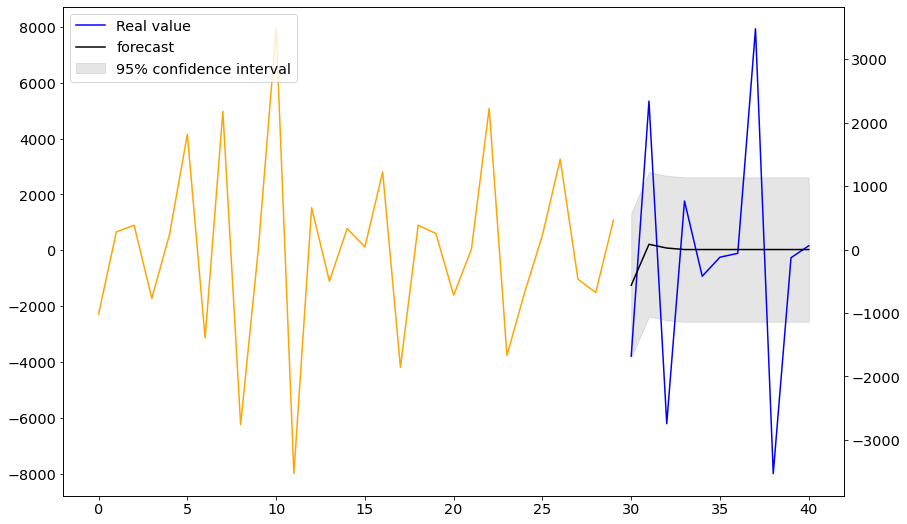

In [ ]:
fig, ax = plt.subplots(figsize = (14,9))
ax.plot(treino_60.index, treino_60, color='orange')
ax2 = ax.twinx()
ax2.plot(teste_60.index, teste_60, color='blue', label = 'Real value')
ax2.plot(teste_60.index, predito_AUTOARIMA, color='black',label='forecast')
ax2.fill_between(teste_60.index, (predito_AUTOARIMA .values -ci.values), (predito_AUTOARIMA .values+ci.values), color='gray', alpha=.2,label = "95% confidence interval")

plt.legend()
plt.show()

###Métricas para avaliar o modelo

Para analisar se as previsões estão com os valores próximos dos dados reais deve-se fazer a medição do erro, o erro (ou resíduo) neste caso é basicamente $y_{real} - y_{previsão}$

Avalia-se o erro nos dados de treino para verificar se o modelo tem boa assertividade, e valida-se o modelo verificando o erro nos dados de teste (dados que não foram "vistos" pelo modelo).

Abaixo estão as principais métricas usadas para avaliar modelos de séries temporais:

####MEAN FORECAST ERROR - (ERRO MÉDIO DA PREVISÃO ou VIÉS)

O erro médio da previsão nada mais é do que a média dos erros da série avaliada, os valores podem ser positivos ou negativos. Essa métrica sugere que o modelo tende a fazer previsões acima do real (erros negativos) ou abaixo do real (erros positivos), desse modo também pode-se dizer que o erro médio é o viés do modelo.

#### MAE - MEAN ABSOLUTE ERROR - (ERRO MÉDIO ABSOLUTO)

Essa métrica é muito semelhante ao erro médio da previsão mencionado acima, a única diferença é o erro com valor negativo, ou seja, a previsão com valor maior que o número real, é transformado em positivo e posteriormente a média é calculada.

Essa métrica é muito usada em séries temporais, pois há casos que o erro negativo pode zerar o positivo ou dar uma ideia que o modelo é preciso, no caso do MAE isso não acontece, pois essa métrica mostra o quanto a previsão está longe dos valores reais, independente se acima ou abaixo

####MSE - MEAN SQUARED ERROR - (ERRO QUADRÁTICO MÉDIO)

Essa métrica coloca mais peso nos erros maiores, pois cada valor individual do erro é elevado ao quadrado e posteriormente a média desses valores é calculada. Assim, essa métrica é muito sensível à outliers e coloca bastante peso nas previsões com erros mais significativos.

Diferente do MAE e MFE, os valores do MSE estão em unidades quadráticas e não na unidade do modelo.

####RMSE - ROOT MEAN SQUARED ERROR - (ERRO QUADRÁTICO MÉDIO DA RAIZ)

Essa métrica é simplesmente a raiz quadrada do MSE, onde o erro volta a ter a unidade de medida do modelo (R$/m3), ela é muito usada em séries temporais porque é mais sensível à erros maiores devido ao processo de elevação ao quadrado que a originou.

####MAPE - MEAN ABSOLUTE PERCENTAGE ERROR - (ERRO PERCENTUAL MÉDIO ABSOLUTO)

Essa é outra métrica interessante de ser usada, geralmente usada em relatórios gerenciais, pois o erro é medido em termos percentuais e pode-se comparar o erro percentual do modelo de um produto X com o erro percentual de um produto Y.

O cálculo dessa métrica pega o valor absoluto do erro dividido pelo preço real e posteriormente é calculada a média:

$$MAPE = \frac{100%}{n} \sum _{i = 1}^n \begin{vmatrix}
\frac{y_{real} - y_{previsto}}{y_{real}}\end{vmatrix}$$ 

Vamos criar uma função para avaliar o erro dos dados de treino e teste com várias métricas de avaliação:


In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error,r2_score

def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    
    grupo_erro = [round(vies,2), mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

Com as métricas fica mais claro ainda, o modelo não é bom.

In [ ]:
check_erro(teste_60['produto_quantidade'].values,predito_ARIMA,'Produto B0', 'Toda a série' )

,Produto B0
Toda a série,
VIÉS,-1.524100e+02
MSE,3.887966e+06
RMSE,1.971793e+03
MAE,1.410608e+03
MAPE,1.022071e+02


Mesmo com apenas 4 passos na frente o modelo é ruim. 

Vamos utilizar os nossos 60 dias para tentar prever apenas 4 valores na frente.

In [ ]:
check_erro(teste_60['produto_quantidade'].values[:4],predito_ARIMA[:4],'Produto B0', '4 passos pra frente' )

,Produto B0
4 passos pra frente,
VIÉS,-2.375100e+02
MSE,4.472002e+06
RMSE,2.114711e+03
MAE,1.925850e+03
MAPE,1.010621e+02


O auto-ARIMA também não se saiu bem.

Vamos treinar o nosso modelo com 30, 60 e 90 dias para prever apenas 4 valores na frente. Em todos os 3 testes vamos usar autoarima.

In [ ]:
check_erro(teste_60['produto_quantidade'].values[:4],predito_AUTOARIMA[:4],'Produto B0', '4 passos pra frente' )

,Produto B0
4 passos pra frente,
VIÉS,-2.161100e+02
MSE,3.648405e+06
RMSE,1.910080e+03
MAE,1.726870e+03
MAPE,9.093771e+01


##Treinando modelos autoarima para enxergar apenas 4 passos a frente.

###30 dias

In [ ]:
treino30 = treino30.reset_index(drop = True)
treino30 = treino30.diff().dropna()

In [ ]:
teste

,produto_quantidade
nota_data_emissao,
2021-09-27,180
2021-09-28,2400
2021-09-29,420
2021-09-30,720


In [ ]:
modelo_autoarima.fit(treino30)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=386.791, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=375.090, Time=0.20 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=384.851, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=382.822, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=375.010, Time=0.11 sec
 ARI

AutoARIMA(error_action='ignore', start_p=1, start_q=1, stepwise=False,
          trace=True)

In [ ]:
predito_AUTOARIMA = modelo_autoarima.predict(n_periods = 4)

Com 30 dias nosso modelo ficou bem ruim.

In [ ]:
check_erro(teste['produto_quantidade'].values,predito_AUTOARIMA,'Produto B0','4 passos na frente' )

,Produto B0
4 passos na frente,
VIÉS,9.302400e+02
MSE,3.383833e+06
RMSE,1.839520e+03
MAE,1.614226e+03
MAPE,3.181153e+02


### 60 dias

In [ ]:
treino60.head() # todos os procedimentos foram feitos anteriormente

,produto_quantidade
0,-2280.0
1,660.0
2,900.0
3,-1720.0
4,585.0


In [ ]:
modelo_autoarima.fit(treino60)
predito_AUTOARIMA = modelo_autoarima.predict(n_periods = 4)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=775.810, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=747.697, Time=0.73 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=763.336, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=753.966, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=745.276, Time=0.67 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=3.33 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=753.171, Time=0.60 sec


Novamente o modelo ficou ruim.

In [ ]:
check_erro(teste['produto_quantidade'].values,predito_AUTOARIMA,'Produto B0','4 passos na frente' )

,Produto B0
4 passos na frente,
VIÉS,7.257000e+02
MSE,2.411209e+06
RMSE,1.552807e+03
MAE,1.272429e+03
MAPE,2.373439e+02


###90 dias

In [ ]:
treino90 = treino90.reset_index(drop = True)
treino90 = treino90.diff().dropna()

In [ ]:
modelo_autoarima.fit(treino90)
predito_AUTOARIMA = modelo_autoarima.predict(n_periods = 4)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1245.972, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1146.153, Time=0.41 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1152.507, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1208.877, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1147.018, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1187.451, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1141.741, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1147.880, Time=0.37 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=117

Também ficou ruim.

In [ ]:
check_erro(teste['produto_quantidade'].values,predito_AUTOARIMA,'Produto B0','4 passos na frente' )

,Produto B0
4 passos na frente,
VIÉS,9.658800e+02
MSE,2.489104e+06
RMSE,1.577690e+03
MAE,1.064305e+03
MAPE,1.020377e+02


Os dados são poucos representativos. Modelos de séries temporais clássicos não conseguem lidar. Vamos tentar gerar previsões com modelos de machine learning mais sofisticados.

#Machine Learning

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet
!pip install auto_ts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9536169 sha256=6151173cb563310f516894540b9b3d65fb08000f1cc46c3e7adbeeb5b18e9bd1
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.1.0
    Uninstalling cmdstanpy-1.1.0:
      Successfully uninstalled cmdstan

In [ ]:
df = pd.read_excel('/content/time_series_data.xlsx')
df.drop_duplicates(inplace= True)
df['nota_data_emissao'] = pd.to_datetime(df['nota_data_emissao'], format = '%Y%m%d')
df = df[df['produto_descricao'] == 'B0']

In [ ]:
ts_column = 'nota_data_emissao'
target = 'produto_quantidade'

In [ ]:
df = df[['nota_data_emissao','produto_quantidade']]

In [ ]:
traindata = df[df['nota_data_emissao'] < '2021-09-26']
teste = df[df['nota_data_emissao'] >= '2021-09-26']

Start of Fit.....
    Target variable given as = produto_quantidade
Start of loading of data.....
    Inputs: ts_column = nota_data_emissao, sep = ,, target = ['produto_quantidade']
    Using given input: pandas dataframe...
    nota_data_emissao column exists in given train data...
    train data shape = (838, 1)
Alert: Could not detect strf_time_format of nota_data_emissao. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is already stationary
There is no differencing needed in this datasets for VAR model


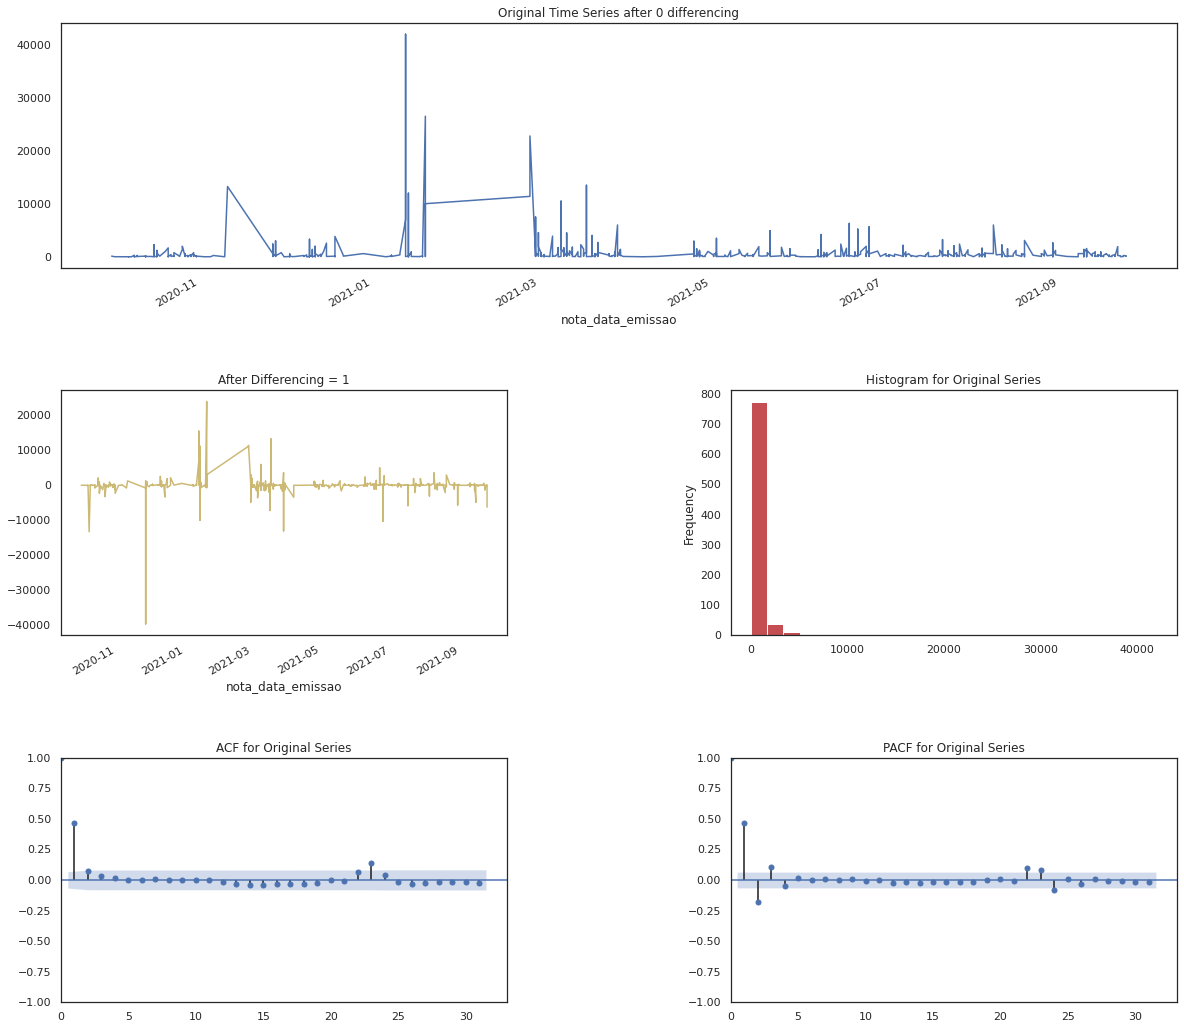

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100.0}
    Fit-Predict data (shape=(838, 2)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 813 Test Shape: 5
    RMSE = 335.94
    Std Deviation of actuals = 253.65
    Normalized RMSE (as pct of std dev) = 132%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 818 Test Shape: 5
    RMSE = 558.19
    Std Deviation of actuals = 25.38
    Normalized RMSE (as pct of std dev) = 2200%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 823 Test Shape: 5
    RMSE = 1,178.00
    Std Deviation of actuals = 879.69
    Normalized RMSE (as pct of std dev) = 1

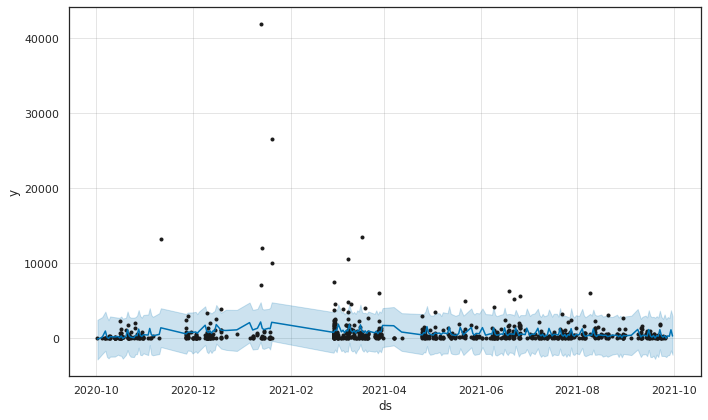

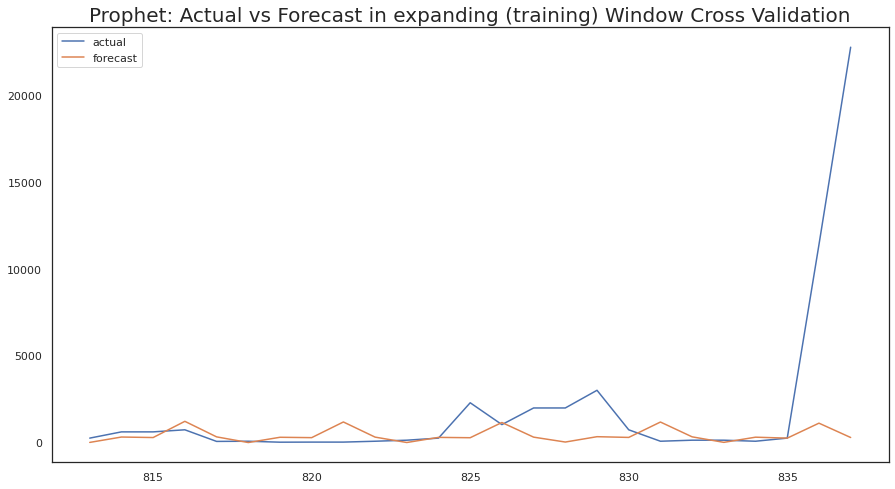

<Figure size 1080x576 with 0 Axes>

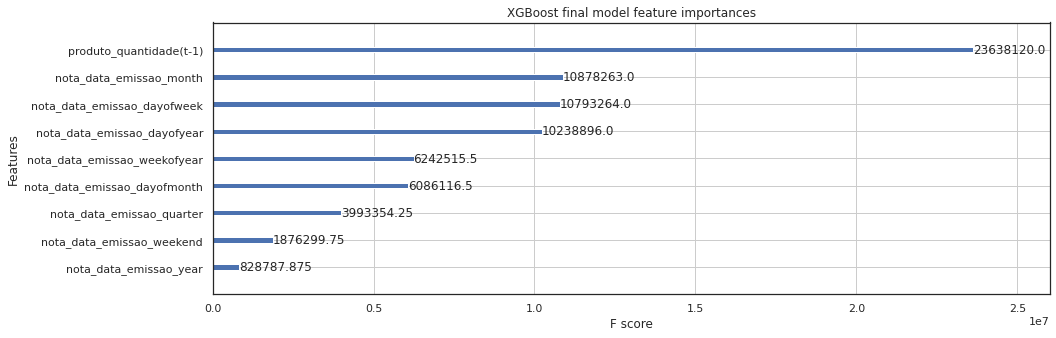

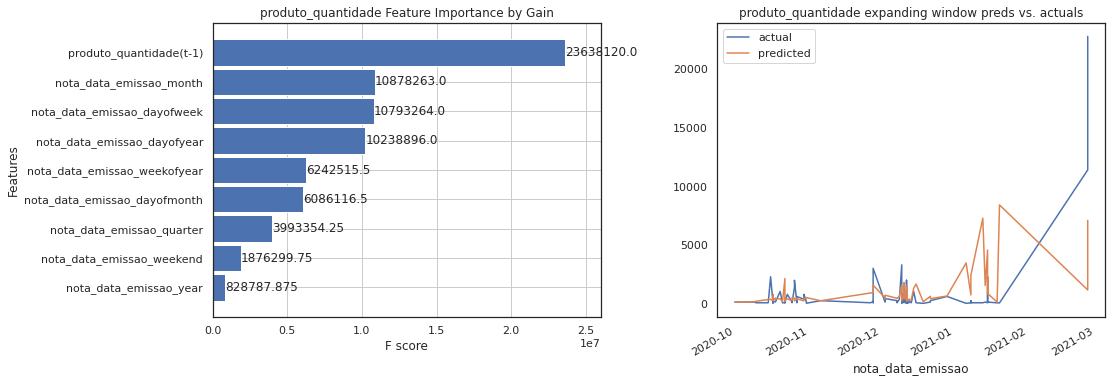

In [ ]:
from auto_ts import auto_timeseries # biblioteca prophet bombada

model = auto_timeseries(score_type='rmse',
                time_interval='D',
                model_type=['best'],dask_xgboost_flag=False,
                verbose=2)
model.fit(traindata, ts_column,target)

In [ ]:
predictions  = model.predict(testdata=teste, model='best')
predictions.head()


Predicting using test dataframe shape = (9, 2) for ML model
For large datasets: ML predictions will take time since it has to predict each row and use that for future predictions...
    Using given input: pandas dataframe...
    Alert: No strf_time_format given for nota_data_emissao. Provide strf_time format during "setup" for better results.
ML predictions completed


,produto_quantidade,mean_se,mean_ci_lower,mean_ci_upper
nota_data_emissao,,,,
2021-09-30,6734.594238,NaN,NaN,NaN
2021-09-30,6117.916016,NaN,NaN,NaN
2021-09-27,6139.024414,NaN,NaN,NaN
2021-09-30,6117.916016,NaN,NaN,NaN
2021-09-29,6205.954590,NaN,NaN,NaN


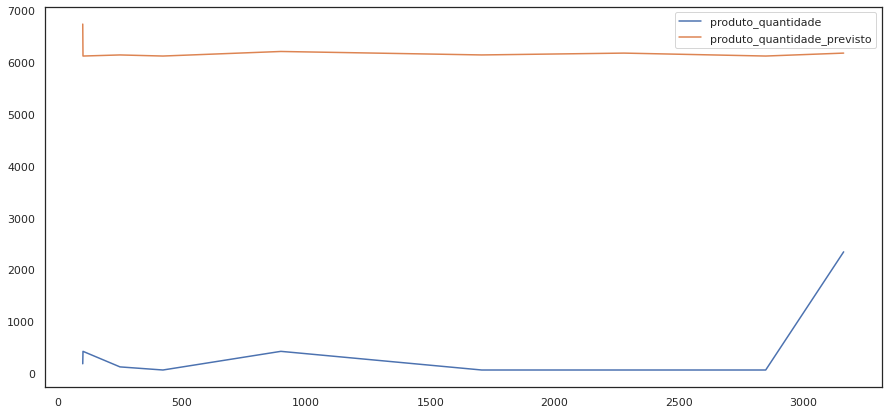

In [ ]:


tes_pred = teste[[target]]
tes_pred['produto_quantidade_previsto'] = predictions['produto_quantidade'].values
pd.concat([tes_pred[target], tes_pred['produto_quantidade_previsto']],axis=1).dropna(axis=1).plot(figsize=(15,7));



### Métricas de validação do modelo machine learning.

Nosso modelo de previsão ainda é ruim, porém ficou bem melhor que os nossos modelos clássicos.


-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 5800.16
    MSE (Mean Squared Error = 34175328.86
    MAPE (Mean Absolute Percent Error) = 5786%
    RMSE (Root Mean Squared Error) = 5845.9669
    Normalized RMSE (MinMax) = 256%
    Normalized RMSE (as Std Dev of Actuals)= 793%


(5845.966888017529, 792.605170881467)

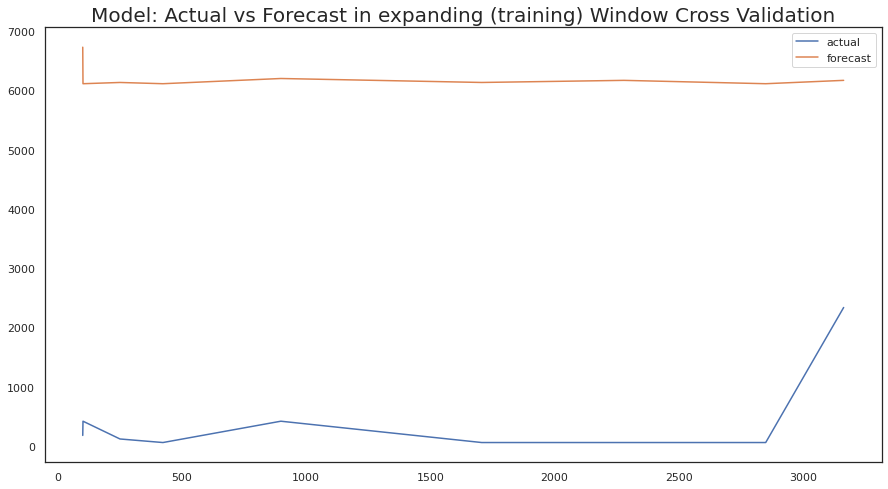

In [ ]:
from auto_ts import print_ts_model_stats
print_ts_model_stats(tes_pred[target], tes_pred['produto_quantidade_previsto'])


## Vamos diminuir os dias do nosso modelo, apenas 20 dias

In [ ]:
traindata = df[df['nota_data_emissao'] < '2021-09-26']
teste = df[df['nota_data_emissao'] >= '2021-09-26']

In [ ]:
dias20 = traindata.nota_data_emissao.max() - pd.Timedelta(days = 20)
treino20 = traindata[traindata.nota_data_emissao > dias20]

Start of Fit.....
    Target variable given as = produto_quantidade
Start of loading of data.....
    Inputs: ts_column = nota_data_emissao, sep = ,, target = ['produto_quantidade']
    Using given input: pandas dataframe...
    nota_data_emissao column exists in given train data...
    train data shape = (65, 1)
Alert: Could not detect strf_time_format of nota_data_emissao. Provide strf_time format during "setup" for better results.
setting maxlag to a low number = 5

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 5 regression: c autolag: BIC
Data is already stationary
There is no differencing needed in this datasets for VAR model


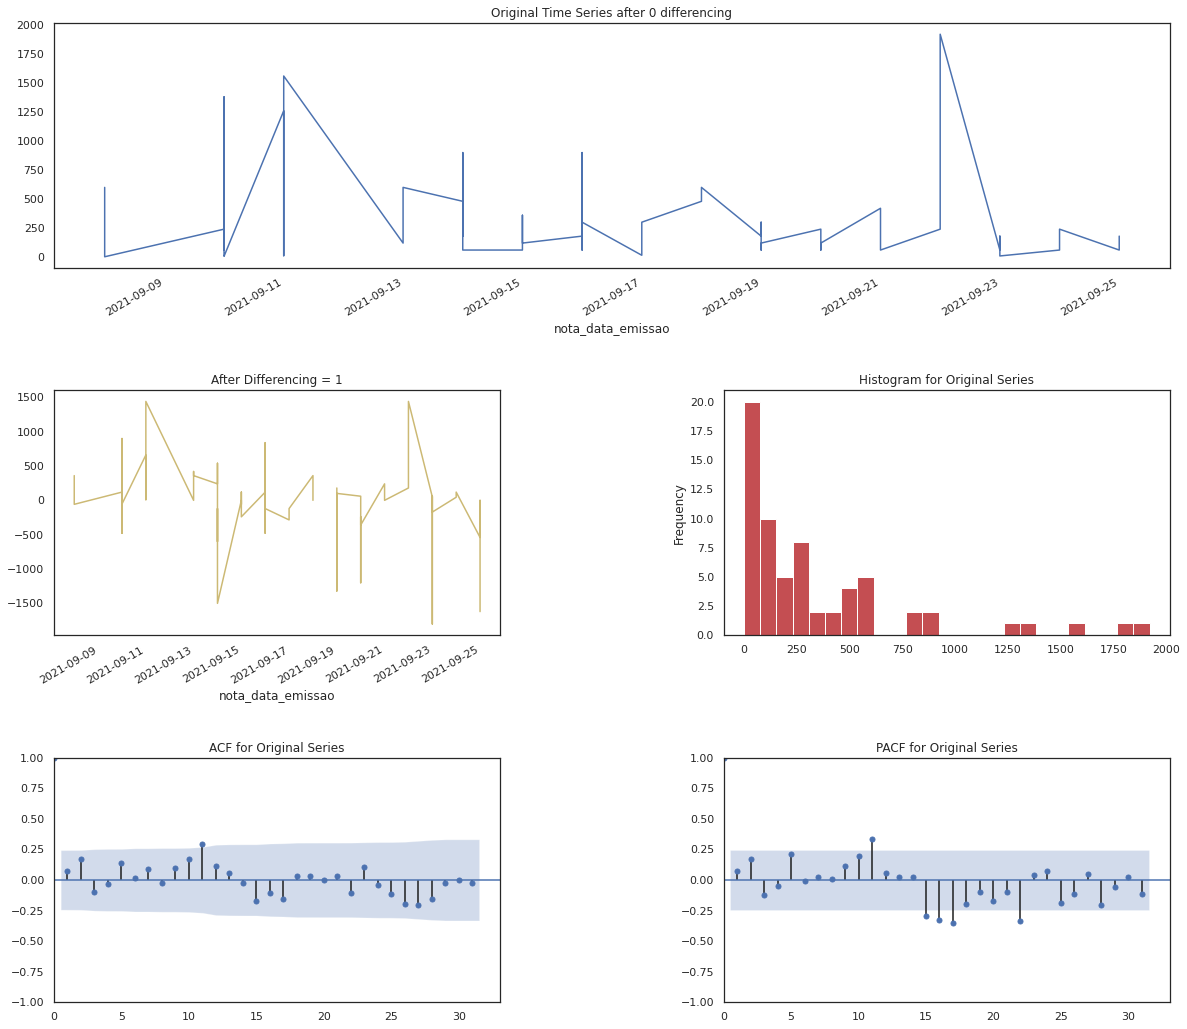

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100.0}
    Fit-Predict data (shape=(65, 2)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 40 Test Shape: 5
    RMSE = 555.93
    Std Deviation of actuals = 459.15
    Normalized RMSE (as pct of std dev) = 121%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 45 Test Shape: 5
    RMSE = 811.07
    Std Deviation of actuals = 599.52
    Normalized RMSE (as pct of std dev) = 135%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 50 Test Shape: 5
    RMSE = 284.93
    Std Deviation of actuals = 58.79
    Normalized RMSE (as pct of std dev) = 485%
Cro

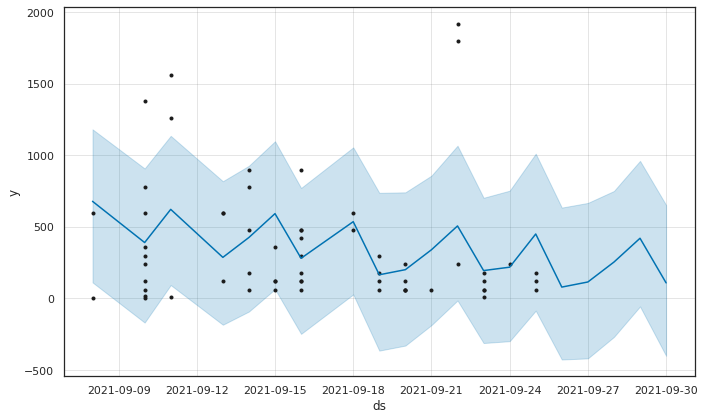

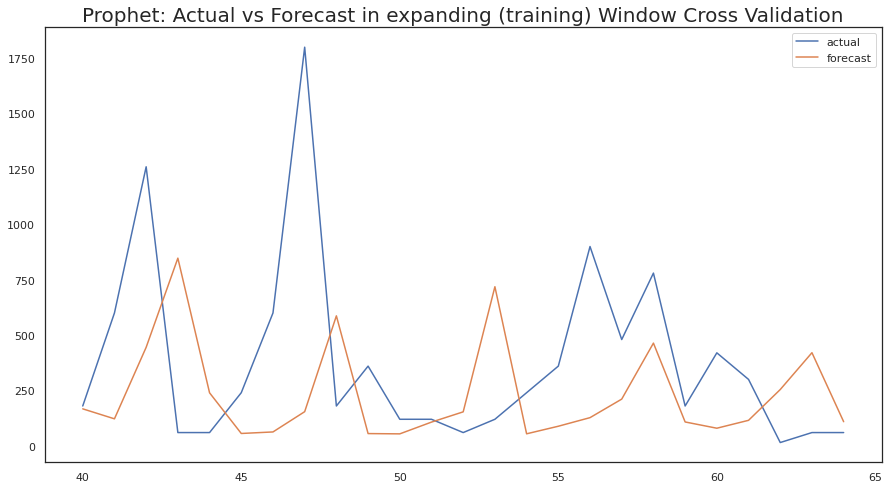

<Figure size 1080x576 with 0 Axes>

In [ ]:


model = auto_timeseries(score_type='rmse',
                time_interval='D',
                model_type=['best'],dask_xgboost_flag=False,
                verbose=2)
model.fit(treino20, ts_column,target)

In [ ]:
predictions  = model.predict(testdata=teste, model='best')
predictions.head()


Predicting using test dataframe as input for Prophet model
Building Forecast dataframe. Forecast Period = 12


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
16,2021-09-26,226.786819,-445.404877,582.629592,226.786442,226.787237,-153.549266,-153.549266,-153.549266,-153.549266,-153.549266,-153.549266,0.0,0.0,0.0,73.237553
17,2021-09-27,213.404512,-427.598315,672.512298,213.403282,213.405823,-108.339439,-108.339439,-108.339439,-108.339439,-108.339439,-108.339439,0.0,0.0,0.0,105.065072
18,2021-09-28,200.022204,-240.405605,806.490950,200.019787,200.024565,51.500083,51.500083,51.500083,51.500083,51.500083,51.500083,0.0,0.0,0.0,251.522287
19,2021-09-29,186.639896,-192.609813,857.895955,186.636181,186.643593,164.608882,164.608882,164.608882,164.608882,164.608882,164.608882,0.0,0.0,0.0,351.248778
20,2021-09-30,173.257589,-447.785571,636.711750,173.252414,173.263352,-76.638577,-76.638577,-76.638577,-76.638577,-76.638577,-76.638577,0.0,0.0,0.0,96.619012


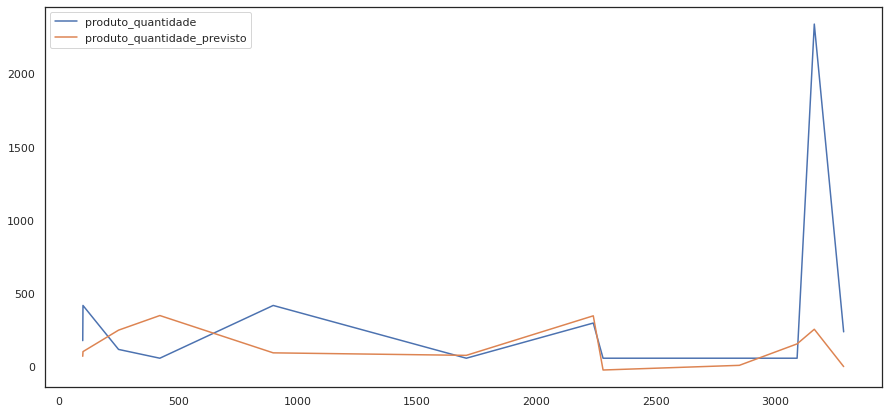

In [ ]:

tes_pred = teste[[target]]
tes_pred['produto_quantidade_previsto'] = predictions['yhat'].values
pd.concat([tes_pred[target], tes_pred['produto_quantidade_previsto']],axis=1).dropna(axis=1).plot(figsize=(15,7));


# Melhor modelo

Nosso melhor modelo teve uma MAE de 315.25. Considerando a complexidade desses dados, acredito que seja um bom resultado.


-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 315.25
    MSE (Mean Squared Error = 394266.47
    MAPE (Mean Absolute Percent Error) = 118%
    RMSE (Root Mean Squared Error) = 627.9064
    Normalized RMSE (MinMax) = 28%
    Normalized RMSE (as Std Dev of Actuals)= 98%


(627.906420622992, 98.32885793489517)

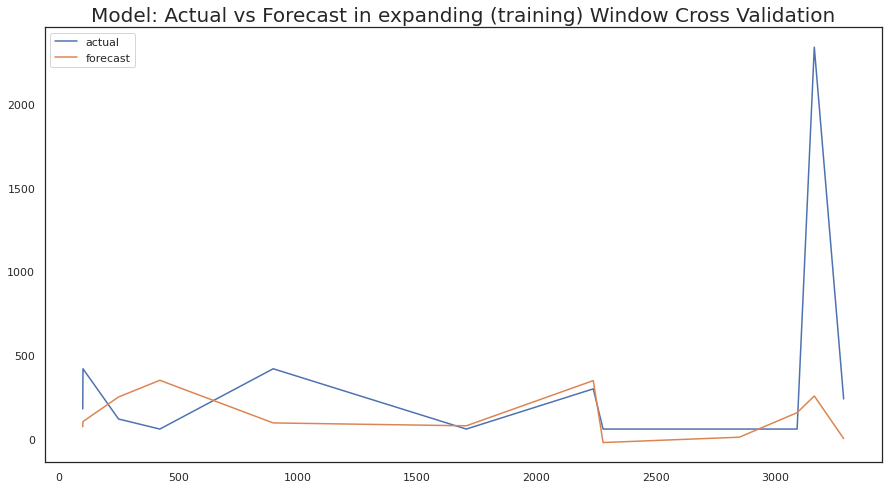

In [ ]:
from auto_ts import print_ts_model_stats
print_ts_model_stats(tes_pred[target], tes_pred['produto_quantidade_previsto'])